### For BHR71 JWST Cycle 1 proposal  
Find the number density distribution as a function of K-band magnitude for stars at a nearby field to BHR71

Use CTIO Ks-band image as the starting point

In [1]:
from astropy.io import fits
hdu = fits.open('/Volumes/SD-Mac/Google Drive/research/bhr71/data/photometry/BHR71-NIR/CTIO-ISPI/BHR71ks-mosaiclc.fits')

Preview the image

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -6.066e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.937e+03 [aplpy.core]


/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/aplpy-0.0.dev1030-py3.6.egg/aplpy/colorbar.py:397: UserWarning: This method is not functional at this time
  warnings.warn("This method is not functional at this time")
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/aplpy-0.0.dev1030-py3.6.egg/aplpy/overlays.py:259: UserWarning: Text labels do not have attribute linestyle. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/aplpy-0.0.dev1030-py3.6.egg/aplpy/overlays.py:259: UserWarning: Text labels do not have attribute linewidth. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".format(kwarg))
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/aplpy-0.0.dev1030-py3.6.egg/aplpy/overlays.py:259: UserWarning: Text labels do not have attribute corner. Skipping.
  warnings.warn("Text labels do not have attribute {0}. Skipping.".fo

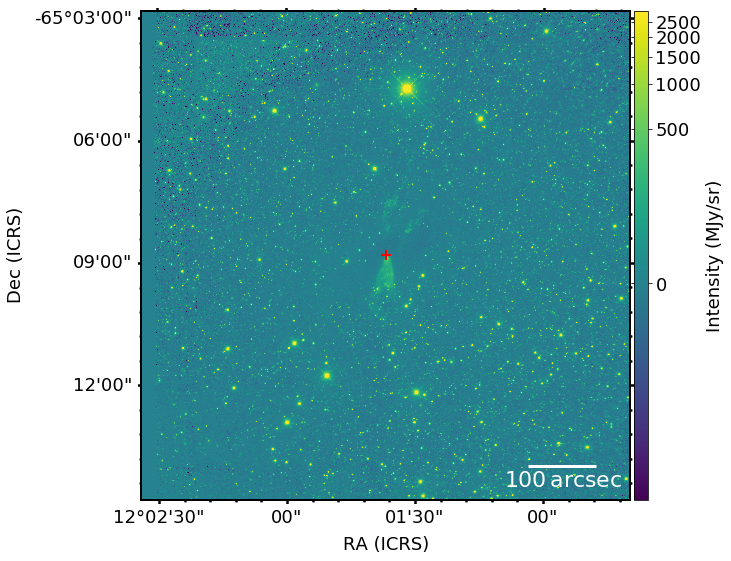

In [2]:
%matplotlib inline
from make_image import make_image
from astropy.coordinates import SkyCoord
from astropy import units as u
center = SkyCoord('12 01 36.81 -65 08 49.22', unit=(u.hourangle, u.deg))
im = make_image('/Volumes/SD-Mac/Google Drive/research/bhr71/data/photometry/BHR71-NIR/CTIO-ISPI/BHR71ks-mosaiclc.fits',
                coord='12 01 36.81 -65 08 49.22', size=0.1, bar_size=100, stretch='log', framecolor='black', plotname='BHR71_CTIO_Ks')

[None, None, None, None]

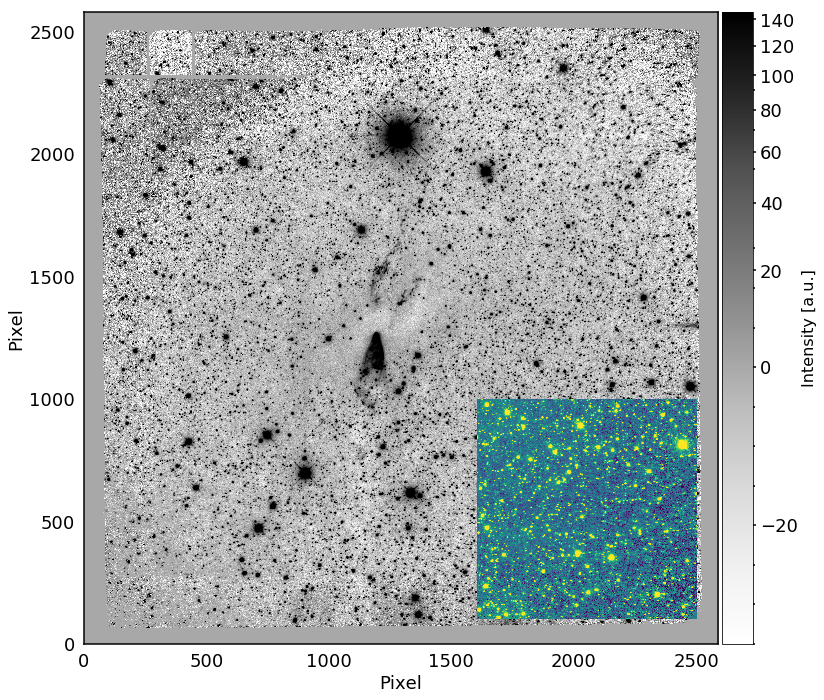

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.visualization import (PercentileInterval, AsinhStretch,
                                   ImageNormalize)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# Create an ImageNormalize object
norm = ImageNormalize(hdu[0].data, interval=PercentileInterval(95), stretch=AsinhStretch())

plot_im = ax.imshow(hdu[0].data, norm=norm, origin='lower', aspect=1, cmap='Greys')

mask = np.ones_like(hdu[0].data)
mask[100:1000, 1600:2500] = 0
im_masked = np.ma.array(hdu[0].data, mask=mask)
ax.imshow(im_masked, norm=norm, origin='lower', aspect=1, cmap='viridis')

im_trimmed = hdu[0].data.copy()[100:1000, 1600:2500]

# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(plot_im, cax=cax)
cb.solids.set_edgecolor("face")
cb.ax.minorticks_on()
cb.ax.set_ylabel('Intensity [a.u.]',fontsize=16)
cb.ax.tick_params('both', width=1.5, which='major', length=3)
cb.ax.tick_params('both', width=1.5, which='minor', length=2)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=18)

ax.set_xlabel('Pixel', fontsize=18)
ax.set_ylabel('Pixel', fontsize=18)
ax.tick_params(axis='both', which='major', width=1.5, labelsize=18, color='white', length=5)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]

Find sources in the image subset

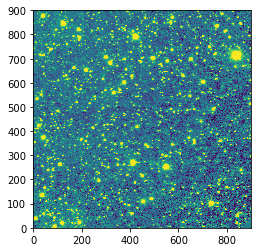

In [12]:
plt.imshow(im_trimmed, norm=norm, origin='lower')

In [13]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(im_trimmed, sigma=3.0, iters=5)
print((mean, median, std))

(-3.2320650476629535, -4.477046, 13.381115538105748)


Use DAOFIND method

In [14]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(im_trimmed - median)    
print(sources) 

 id    xcentroid     ycentroid    ...      flux            mag       
---- ------------- -------------- ... ------------- -----------------
   1  136.99725579 0.362375953625 ... 1.28998276542   -0.276459770061
   2 529.748494305 0.635299154995 ... 4.51094595816    -1.63566906053
   3 716.555178188  1.13976199604 ... 1.14833907202   -0.150175354661
   4 851.566609644 0.818504348237 ... 27.6946190001    -3.60598848714
   5 854.371176112  1.71237457364 ... 12.7321549587    -2.76225478907
   6   45.83062765   1.2296549981 ... 1.11743031207   -0.120551120278
   7 80.0645624791  3.29394106203 ... 2.62253136903    -1.04680172912
   8   705.9961388  6.11564617827 ... 3.54284214962    -1.37337950723
   9 91.0368703717  7.12657056313 ... 135.938049837    -5.33335258814
  10 179.388669657  7.39348744612 ... 2.58359249189    -1.03056003445
 ...           ...            ... ...           ...               ...
1407 825.120621836  893.952842163 ... 2.90233889863    -1.15687030627
1408 102.646229872  

Plot the found sources

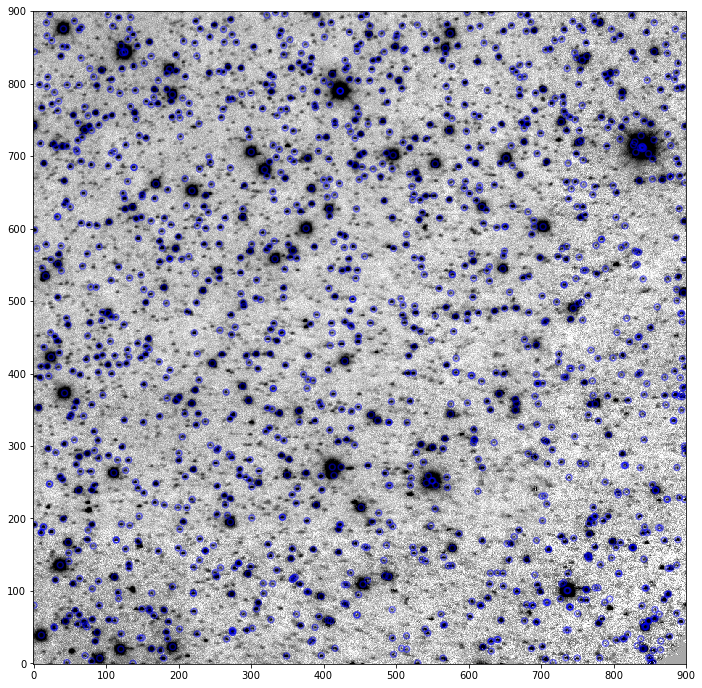

In [20]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)

norm = ImageNormalize(hdu[0].data, interval=PercentileInterval(95), stretch=AsinhStretch())

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(im_trimmed, cmap='Greys', origin='lower', norm=norm)

apertures.plot(color='blue', lw=1.5, alpha=0.5)

Plot the distribution of star counts

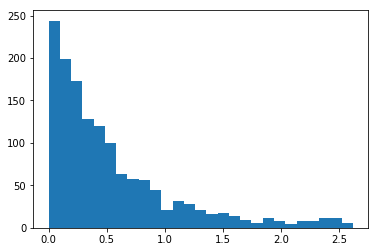

In [29]:
from astropy.visualization import hist

fig = plt.figure()
ax = fig.add_subplot(111)

h = hist(np.log10(sources['flux']), bins='knuth', ax=ax)